In [3]:
TRAIN_DATA_DIR = 'data/semeval-2023-task-1-V-WSD-train-v1/train_v1/train_images_v1'
TRAIN_DATA_FILE = 'data/semeval-2023-task-1-V-WSD-train-v1/train_v1/train.data.v1.txt'
TRAIN_GOLD_FILE = 'data/semeval-2023-task-1-V-WSD-train-v1/train_v1/train.gold.v1.txt'

TEST_DATA_DIR = 'data/test_images_resized'
TEST_DATA_FILE = 'data/test.data.v1.1.gold/en.test.data.v1.1.txt'
TEST_GOLD_FILE = 'data/test.data.v1.1.gold/en.test.gold.v1.1.txt'

BATCH_SIZE = 64

In [2]:
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = None

import pytorch_lightning as pl
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

# Set the random seed for reproducibility
torch.manual_seed(42)
# Enable TPU cores
torch.set_float32_matmul_precision('medium')

In [3]:
# Load TensorBoard extension
%load_ext tensorboard

In [1]:
# Import modules
from src.dataset import dataset
from src.utils import utils
from src.model import pretrained

# Reload all modules
import importlib
importlib.reload(dataset)
importlib.reload(utils)
importlib.reload(pretrained)

<module 'src.model.pretrained' from '/home/luigi/Documents/HotNLP/homework3/src/model/pretrained.py'>

## Dataset

In [4]:
utils.resize_images(TRAIN_DATA_DIR)
utils.resize_images(TEST_DATA_DIR)

Resizing images:   0%|          | 0/12999 [00:00<?, ?it/s]

Resizing images:   0%|          | 0/8100 [00:00<?, ?it/s]

In [12]:
# Create the dataset
train_WSD_dataset = dataset.VisualWSDDataset(
    data_dir=TRAIN_DATA_DIR,
    data_file=TRAIN_DATA_FILE,
    gold_file=TRAIN_GOLD_FILE)

train_dataloader = DataLoader(train_WSD_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

Building VisualWSDDataset:   0%|          | 0/12869 [00:00<?, ?it/s]

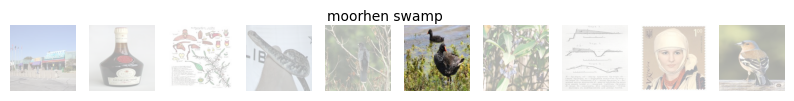

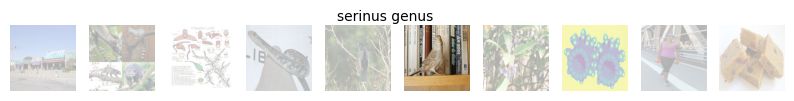

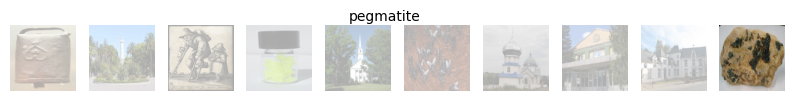

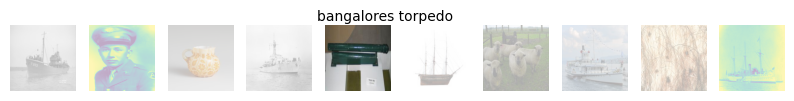

In [13]:
# Function to display images
def display_images(input_ids, images, gold_label_index, decode_text_fn):
    fig, axs = plt.subplots(1, len(images), figsize=(10,1))
    for i, image in enumerate(images):
        img = Image.open(image) #.numpy().transpose((1, 2, 0))
        axs[i].imshow(img, alpha = 1 if i==gold_label_index.item() else 1/3)
        axs[i].axis('off')
    # Adding a central title to the figure
    decoded_text = decode_text_fn(input_ids.tolist(), skip_special_tokens=True)
    fig.suptitle(f"{decoded_text}", fontsize=10)
    plt.show()

# Loop through the dataset
for i, sample in enumerate(train_WSD_dataset):
    display_images(sample[0], sample[2], sample[3], train_WSD_dataset.tokenizer.decode)
    if i==3: break

In [15]:
# Define a transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)), # For example, resize to 224x224 for CNNs
    transforms.Lambda(lambda x: x.convert('RGB')),  # Convert all images to RGB
    transforms.ToTensor(),
])

triplets_dataset = dataset.TripletsWSDDataset(train_WSD_dataset, transform=transform)

Generating triplets:   0%|          | 0/12869 [00:00<?, ?it/s]

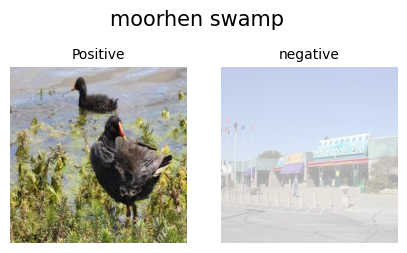

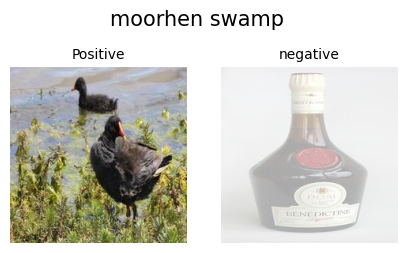

In [17]:
# Function to display images
def display_triplets(input_ids, pos_image, neg_image, decode_text_fn):
    fig, axs = plt.subplots(1, 2, figsize=(5,3))
    for i, image in enumerate([pos_image, neg_image]):
        img = image.numpy().transpose((1, 2, 0))
        axs[i].imshow(img, alpha = 1 if i==0 else 1/3)
        axs[i].axis('off')
        axs[i].set_title('Positive' if i==0 else 'negative', fontsize=10)
    # Adding a central title to the figure
    decoded_text = decode_text_fn(input_ids.tolist(), skip_special_tokens=True)
    fig.suptitle(f"{decoded_text}", fontsize=15)
    plt.show()

# Loop through the DataLoader
for i, sample in enumerate(triplets_dataset):
    display_triplets(sample[0], sample[2], sample[3], train_WSD_dataset.tokenizer.decode)
    if i==1: break

# Model1

In [19]:
# Set the random seed for reproducibility
torch.manual_seed(42)

# Initialize model
pretrained_model = pretrained.VisualWSDModel()

# Define parameters
split_ratio = 0.8
max_epochs = 5

# Calculate split sizes
calculate_split_sizes = lambda dataset_size, split_ratio: (int(split_ratio * dataset_size), dataset_size - int(split_ratio * dataset_size))

# Splitting the dataset
train_size, eval_size = calculate_split_sizes(len(triplets_dataset), split_ratio)
train_dataset, eval_dataset = random_split(triplets_dataset, [train_size, eval_size])

# Creating dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_dataloader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Training the model
trainer = pl.Trainer(max_epochs=max_epochs)
trainer.fit(pretrained_model, train_dataloader, val_dataloader)

# Start TensorBoard within the notebook
%tensorboard --logdir lightning_logs/

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

/home/luigi/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/luigi/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/luigi/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [01:34<00:00, 495kB/s] 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a C

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/home/luigi/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [20]:
def display_preds(input_ids, attention_mask, images, gold_label_index, pred_index, cosine_similarities, decode_text_fn):
    fig, axs = plt.subplots(1, len(images), figsize=(10, 1))

    for i, image in enumerate(images):
        img = image.numpy().transpose((1, 2, 0))
        axs[i].imshow(img, alpha=1 if i == pred_index.item() else 1/3)
        axs[i].axis('off')

        # Add a red border for the gold label image
        if i == gold_label_index.item():
            rect = patches.Rectangle((-0.5, -0.5), img.shape[1]+1, img.shape[0]+1, linewidth=2, edgecolor='r', facecolor='none')
            axs[i].add_patch(rect)

        # Display cosine similarity score
        similarity_score = cosine_similarities[i].item()
        axs[i].text(0, -2, f"{similarity_score:.2f}", color='blue', fontsize=8, ha='left')

    # Adding a central title to the figure
    decoded_text = decode_text_fn(input_ids.tolist(), skip_special_tokens=True)
    fig.suptitle(f"{decoded_text}", fontsize=10)
    plt.show()

In [42]:
trial_WSD_dataset = dataset.VisualWSDDataset(
    data_dir=TEST_DATA_DIR,
    data_file=TEST_DATA_FILE,
    gold_file=TEST_GOLD_FILE)

Building VisualWSDDataset:   0%|          | 0/463 [00:00<?, ?it/s]

In [43]:
correct_predictions = 0

with torch.no_grad():
    # Loop through the dataset
    for i, sample in enumerate(tqdm(trial_WSD_dataset, 'Testing the model')):
        # Initialize a tensor to store similarities
        similarities = torch.zeros(len(sample[2]))

        # Iterate over the images
        for j, image in enumerate(sample[2]):
            text_embedding, image_embedding = pretrained_model(
                sample[0].unsqueeze(0).to(pretrained_model.device), 
                sample[1].unsqueeze(0).to(pretrained_model.device), 
                transform(Image.open(image)).unsqueeze(0).to(pretrained_model.device))
            # Store the similarity directly in the tensor
            similarities[j] = F.cosine_similarity(text_embedding, image_embedding)

        # Get the index of the maximum similarity score
        predicted_index = torch.argmax(similarities)

        # Increment correct predictions if the prediction matches the gold label
        if predicted_index == sample[3]:
            correct_predictions += 1

# Calculate accuracy
accuracy = correct_predictions / len(trial_WSD_dataset)
print(f"Accuracy: {accuracy:.4f}")


Testing the model:   0%|          | 0/463 [00:00<?, ?it/s]

Accuracy: 0.0864


# CLIP

In [7]:
import clip

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [ ]:
clip_dataset = dataset.VisualWSDDatasetCLIP(
    data_dir=TEST_DATA_DIR,
    data_file=TEST_DATA_FILE,
    gold_file=TEST_GOLD_FILE,
)

In [5]:
def get_text_and_image_embeddings(model, text, image, device):
    # Preprocess and tokenize text
    text = clip.tokenize([text]).to(device)

    # Move image to the correct device
    image = image.unsqueeze(0).to(device)

    # Calculate features
    with torch.no_grad():
        text_features = model.encode_text(text)
        image_features = model.encode_image(image)

    # Normalize features to compute similarity
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)

    return text_features, image_features

# Example usage
for label, images, gold_index in clip_dataset:
    similarities = []
    for image in images:
        text_features, image_features = get_text_and_image_embeddings(model, label, image, device)
        similarities.append(torch.matmul(text_features, image_features.T))
    print(torch.argmax(torch.cat(similarities)), gold_index)
    break
